In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
import keras
from keras import optimizers, regularizers
from keras.layers import Input, Embedding, Flatten, Lambda, Dense, Reshape, LSTM, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import itertools
from collections import Counter
# from utils import data_merger, filter_data
import random
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt
import re
# import seaborn as sns

d:\proyek python\env\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Read the dataset
data = pd.read_excel('./dataset.xlsx', sheet_name='main')
df = pd.DataFrame(data)

In [3]:
dfLabel, dfValue = list(df)[1], list(df)[2::]

In [4]:
questionClass = dict(zip(range(len(df['q'])), df['q']))

In [5]:
search_value = 'Bagaimana Anda menghadapi tren kuliner dan bagaimana Anda berencana untuk tetap relevan di pasar?'
keys_for_value = [key for key, value in questionClass.items() if value == search_value]

print(keys_for_value[0])

8


In [6]:
len(dfValue)

50

In [7]:
dfKey, dfValue = list(df)[1], list(df)[2::]
answers, labels = [], []
for i in range(len(dfValue)):
    for j in range(len(df[dfValue[i]])):
        answer = df[dfValue[i]][j]
        if pd.isna(answer): continue
        answers.append(answer)
        labels.append([key for key, value in questionClass.items() if value == df[dfKey][j]][0])

In [8]:
wordList = []
for item in answers:
    temp = item.split()
    for x in temp:
        wordList.append(x.lower())
result = dict(Counter(wordList))
commonworddata = sorted(result.items(), key=lambda x: x[1], reverse=True)
commonworddata[0], commonworddata[1], commonworddata[2]

(('saya', 6005), ('dan', 4564), ('yang', 3844))

In [9]:
commonword, frequencies = zip(*commonworddata[:30])

In [10]:
def preprocessing_text(sentence):
    words = word_tokenize(sentence)
    filtered_sentence = [word for word in words if word.lower() not in commonword]
    return re.sub(r'[^\w\d\s]', '', ' '.join(filtered_sentence)).replace('  ', ' ')

In [11]:
answers[0]

'Konsep kuliner yang unik bagi saya melibatkan eksplorasi dan penciptaan cita rasa yang belum pernah ditemui sebelumnya. Ini melibatkan penggabungan bahan-bahan, teknik memasak yang inovatif, dan presentasi yang menarik.'

In [12]:
temp = []
for answer in answers:
    temp.append(preprocessing_text(answer))
answers = temp

In [13]:
answers[0]

'Konsep kuliner unik bagi melibatkan eksplorasi penciptaan cita rasa belum pernah ditemui sebelumnya melibatkan penggabungan bahanbahan teknik memasak inovatif presentasi menarik '

In [14]:
totalClass = len(df[dfKey])
totalClass

136

In [15]:
len(answers)

2790

In [16]:
for i in range(135, 140):
    print(f"{i} X: {answers[i]}")
    print(f"{i} Y: {labels[i]}")

135 X: Ketika merasa kelelahan kejenuhan pekerjaan mencoba menjaga keseimbangan beristirahat sejenak berjalanjalan sebentar mendengarkan musik berbicara rekan kerja menyegarkan pikiran kembali energi baik 
135 Y: 135
136 X: Kuliner unik menciptakan makan tak terlupakan mencakup harmoni antara cita rasa tampilan visual interaksi tamu 
136 Y: 0
137 X: peran sebelumnya bertanggung jawab atas seluruh proses perencanaan eksekusi menu restoran memperhatikan baik aspek kreatif maupun aspek bisnis seperti margin keuntungan persediaan 
137 Y: 1
138 X: Salah satu pendekatan terapkan menggunakan perangkat lunak manajemen persediaan canggih mengoptimalkan pengelolaan stok mencegah pemborosan 
138 Y: 2
139 X: Kualitas makanan restoran dijamin pemilihan bahanbahan berkualitas tinggi bekerja sama pemasok tepercaya pasokan bahan baku segar berkualitas Kebersihan prioritas utama mengikuti standar kebersihan ketat 
139 Y: 3


In [388]:
# # shuffling the answer for good training and validation split
# combined = list(zip(combinedData, labels))
# random.shuffle(combined)
# combined1, combined2 = zip(*combined)

In [17]:
# counting vocabulary size to avoid overfitting
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(answers)
vocab_size = len(vectorizer.get_feature_names_out())
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 3512


In [34]:
training_size = round(len(answers) * 0.78)
max_length = 20
embedding_dim = 64

In [35]:
# splitting training and validation data
training_sentences = answers[0:training_size]
testing_sentences = answers[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [36]:
# converting the data into sequences and give a padding
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [37]:
# declare the model
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Conv1D(128, 5, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(totalClass, activation='softmax')
# ])
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, 128, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(totalClass, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 128)           449536    
                                                                 
 global_average_pooling1d_3  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 16)                2064      
                                                                 
 dense_7 (Dense)             (None, 136)               2312      
                                                                 
Total params: 453912 (1.73 MB)
Trainable params: 453912 (1.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
model.compile(loss='SparseCategoricalCrossentropy',optimizer=Adam(),metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=25, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/25
68/68 - 2s - loss: 4.9065 - accuracy: 0.0207 - val_loss: 4.8900 - val_accuracy: 0.0472 - 2s/epoch - 35ms/step
Epoch 2/25
68/68 - 1s - loss: 4.8475 - accuracy: 0.0666 - val_loss: 4.7989 - val_accuracy: 0.0651 - 555ms/epoch - 8ms/step
Epoch 3/25
68/68 - 1s - loss: 4.6491 - accuracy: 0.1043 - val_loss: 4.5574 - val_accuracy: 0.0977 - 532ms/epoch - 8ms/step
Epoch 4/25
68/68 - 1s - loss: 4.2615 - accuracy: 0.1392 - val_loss: 4.1860 - val_accuracy: 0.1645 - 529ms/epoch - 8ms/step
Epoch 5/25
68/68 - 1s - loss: 3.7511 - accuracy: 0.2583 - val_loss: 3.7741 - val_accuracy: 0.2638 - 537ms/epoch - 8ms/step
Epoch 6/25
68/68 - 1s - loss: 3.2067 - accuracy: 0.3975 - val_loss: 3.3985 - val_accuracy: 0.3420 - 519ms/epoch - 8ms/step
Epoch 7/25
68/68 - 1s - loss: 2.6928 - accuracy: 0.5317 - val_loss: 3.1052 - val_accuracy: 0.4055 - 530ms/epoch - 8ms/step
Epoch 8/25
68/68 - 1s - loss: 2.2535 - accuracy: 0.6186 - val_loss: 2.8631 - val_accuracy: 0.4625 - 535ms/epoch - 8ms/step
Epoch 9/25
68/68 -

In [39]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])

    plt.ylim(bottom=0)

    plt.show()

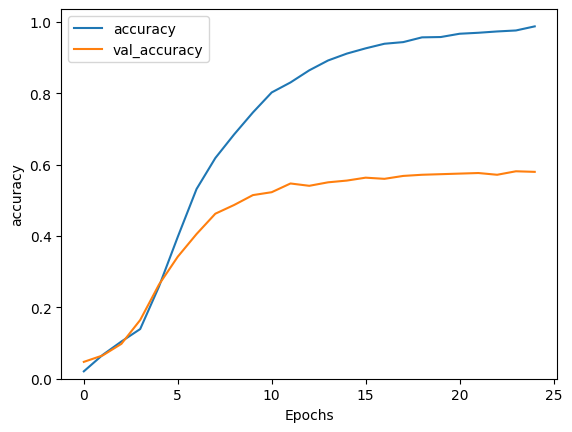

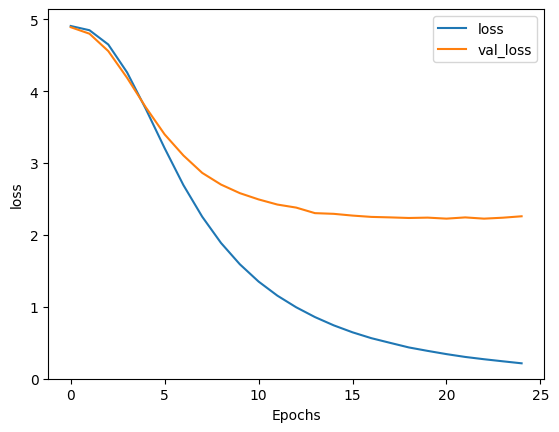

In [40]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

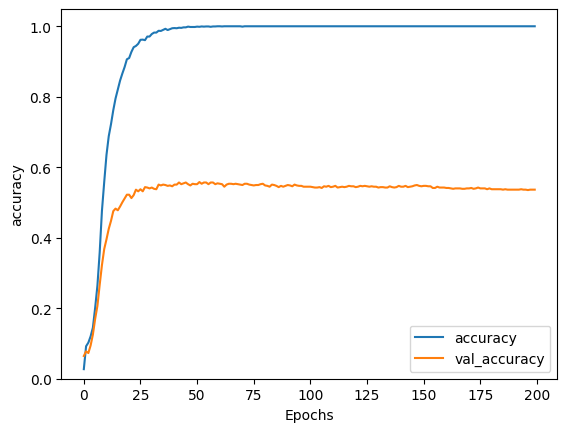

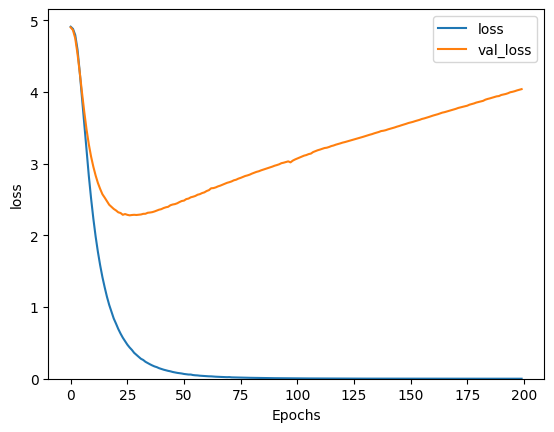

In [46]:

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [95]:
def predict(text):
    preprocessed_text = preprocessing_text(text)
    input_sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_input = pad_sequences(input_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(padded_input)
    
    top_indices = np.argsort(-predictions, axis=1)[0][:5]  # Get indices of top predictions
    top_classes = [questionClass[index] for index in top_indices]  # Retrieve class labels
    top_confidences = [predictions[0][index] for index in top_indices]  # Retrieve confidences
    
    return [(top_classes[i], top_confidences[i]) for i in range(len(top_classes))]

In [96]:
predict("Keyakinan saya tentang posisi ini sebagai langkah yang tepat dalam perkembangan karier saya didukung oleh kesesuaian peran ini dengan tujuan jangka panjang saya. Saya melihat bahwa pekerjaan ini akan membantu saya mendekati tujuan karier saya dengan lebih cepat.")

1/1 [==============================] - 0s 190ms/step


[('Apa yang membuat Anda yakin bahwa posisi ini adalah langkah yang tepat dalam perkembangan karier Anda?',
  0.9829937),
 ('Apa definisi Anda tentang layanan pelanggan yang baik, dan bagaimana Anda menerapkannya dalam pekerjaan Anda?',
  0.012110515),
 ('Apa yang anda ketahui mengenai posisi ini?', 0.0013186038),
 ('Jika anda diterima pada posisi yang anda inginkan, Hal apa yang akan anda lakukan untuk kedepannya?',
  0.0012363149),
 ('Bagaimana Anda mengelola waktu dan deadline dalam proyek desain grafis?',
  0.0005118116)]

In [414]:
text = 'Saya yakin bahwa posisi ini merupakan langkah yang tepat dalam perkembangan karier saya karena perannya sesuai dengan tujuan jangka panjang saya. Saya percaya pekerjaan ini akan mempercepat pencapaian tujuan karier saya.'
predict(text)

1/1 [==============================] - 0s 14ms/step


[('Apakah anda merasa cocok dengan pekerjaan ini?', 0.9147565),
 ('Apa yang membuat Anda yakin bahwa posisi ini adalah langkah yang tepat dalam perkembangan karier Anda?',
  0.04693356),
 ('Apa definisi Anda tentang layanan pelanggan yang baik, dan bagaimana Anda menerapkannya dalam pekerjaan Anda?',
  0.020417448),
 ('Bisakah Anda memberikan contoh situasi di mana Anda menghadapi tantangan besar dan bagaimana Anda mengatasinya?',
  0.016415326),
 ('Apa yang anda ketahui mengenai posisi ini?', 0.0009599515)]

In [415]:
text = 'Keyakinan saya tentang kecocokan posisi ini dengan perkembangan karier saya didukung oleh kesesuaian peran ini dengan tujuan jangka panjang saya. Saya percaya bahwa pekerjaan ini akan mempercepat perjalanan saya menuju tujuan karier.'
predict(text)

1/1 [==============================] - 0s 14ms/step


[('Apa yang membuat Anda yakin bahwa posisi ini adalah langkah yang tepat dalam perkembangan karier Anda?',
  0.9865133),
 ('Apa yang membuat anda tertarik dalam bidang hiburan?', 0.010508898),
 ('Bagaimana Anda mengukur kesuksesan Anda di tempat kerja dan bagaimana Anda berencana untuk mencapainya di perusahaan ini?',
  0.002054791),
 ('Apa yang anda ketahui mengenai posisi ini?', 0.00086638075),
 ('Apa perangkat lunak atau sistem akuntansi yang Anda kuasai dan gunakan dalam pekerjaan Anda?',
  5.6090146e-05)]